# SI 618 Homework 5: Natural Language Processing

## The total score for this assignment will be 100 points, consisting of:
- 10 pt: Overall quality of spelling, grammar, puctuation, etc. of written sentences.
- 10 pt: Codes are written in [PEP 8](https://www.python.org/dev/peps/pep-0008/) style.
- 80 pt: Homework questions. 

In [1]:
MY_UNIQNAME = 'tengdann'

# Download the data:
We will be using a subset of the data from [Project Gutenberg](http://www.gutenberg.org).

>Project Gutenberg is a volunteer effort to digitize and archive cultural works, to "encourage the creation and distribution of eBooks". It was founded in 1971 by American writer Michael S. Hart and is the oldest digital library. Most of the items in its collection are the full texts of public domain books. The project tries to make these as free as possible, in long-lasting, open formats that can be used on almost any computer., Project Gutenberg reached 57,000 items in its collection of free eBooks.

We will use a [cleaned up corpus](https://github.com/aparrish/gutenberg-dammit) that was processed by [Allison Parish](https://www.decontextualize.com/). This processing step was done to standardize metadata and text encoding. The dataset is described on the [project page](https://github.com/aparrish/gutenberg-dammit#gutenberg-dammit). Note that there are plain text files withing subdirectories numbered with the first three digits of the document ID, and there is also a JSON file of document metadata with title, author, and other information.


We created a reduced subset of 4000 documents for the purpose of this assignment that can be downloaded below:

https://drive.google.com/file/d/1V5ep_5veAccCD-YxGlVfv3DsXczBIvv5/view?usp=sharing

This ZIP file is approximately 550 MB compressed, and 1.45 GB uncompressed.

## Q1. (10 pts.) Data cleaning
- (3 pts.) Import the downloaded data
- (2 pts.) Convert to lowercase
- (2 pts.) Remove stopwords 
- (2 pts.) Remove punctuation and any other non-alphabet characters

In [14]:
import re
import os
import spacy
from gensim.models import Word2Vec
from spacy.lang.en.stop_words import STOP_WORDS
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

In [3]:
folders = list(range(0, 2))
for i, folder in enumerate(folders):
    if len(str(folder)) == 1:
        folders[i] = '00' + str(folder)
    elif len(str(folder)) == 2:
        folders[i] = '0' + str(folder)
    else:
        folders[i] = str(folder)

_list = list()
for folder in folders:
    subfolder = './data/hw5_data/gutenberg-dammit-files/%s' % folder
    for file in os.listdir(subfolder):
        if re.search('\d+', file):
            filepath = os.path.join(subfolder, file)
            content = open(filepath, 'r', encoding = 'utf-8').read()
            df = pd.DataFrame(data = {'file': [file], 'content': [content]})
            _list.append(df)
            
raw_data = pd.concat(_list)
raw_data.reset_index(drop = True, inplace = True)
raw_data.head()

,file,content
0,00017.txt,THE BOOK OF MORMON\n\nAn Account Written\n\nBY...
1,00048.txt,THE WORLD FACTBOOK 1992\n\n\n:Afghanistan Geog...
2,00056.txt,When Senator Al Gore was evangelizing support ...
3,00064.txt,[Frontispiece: The cold hollow eye of a revolv...
4,00089.txt,"1. Except as provided in this Annex, each Pa..."


In [4]:
lower_data = raw_data.copy()
lower_data.content = lower_data.content.str.lower()
lower_data.head()

,file,content
0,00017.txt,the book of mormon\n\nan account written\n\nby...
1,00048.txt,the world factbook 1992\n\n\n:afghanistan geog...
2,00056.txt,when senator al gore was evangelizing support ...
3,00064.txt,[frontispiece: the cold hollow eye of a revolv...
4,00089.txt,"1. except as provided in this annex, each pa..."


In [5]:
# nlp = spacy.load(r'C:\Users\dteng\Anaconda\Lib\site-packages\en_core_web_sm\en_core_web_sm-2.0.0')
nlp = spacy.load(r'C:\Users\mrasianman3\Anaconda3\Lib\site-packages\en_core_web_sm\en_core_web_sm-2.0.0')
lower_nostop_data = lower_data.copy()
pat = r'\b(?:{})\b'.format('|'.join(list(STOP_WORDS)))
lower_nostop_data.content = lower_nostop_data.content.str.replace(pat, '')
lower_nostop_data.head()

,file,content
0,00017.txt,book mormon\n\n account written\n\n hand m...
1,00048.txt,world factbook 1992\n\n\n:afghanistan geograp...
2,00056.txt,senator al gore evangelizing support visio...
3,00064.txt,[frontispiece: cold hollow eye revolver sou...
4,00089.txt,"1. provided annex, party shall apply\n ..."


In [6]:
lower_nostop_alpha_data = lower_nostop_data.copy()
pat = r'[\d!?.,\[\]/@#$%^&*():;]'
lower_nostop_alpha_data.content = lower_nostop_alpha_data.content.str.replace(pat, '')
lower_nostop_alpha_data['paragraphs'] = lower_nostop_alpha_data.content.str.split('\n')

def remove_blanks(row):
    cleaned = []
    for item in row['paragraphs']:
        if item != '':
            cleaned.append(item)
            
    return cleaned

lower_nostop_alpha_data.paragraphs = lower_nostop_alpha_data.apply(remove_blanks, axis = 1)
lower_nostop_alpha_data.head()

,file,content,paragraphs
0,00017.txt,book mormon\n\n account written\n\n hand m...,"[ book mormon, account written, hand morm..."
1,00048.txt,world factbook \n\n\nafghanistan geography\n\...,"[ world factbook , afghanistan geography, tota..."
2,00056.txt,senator al gore evangelizing support visio...,[ senator al gore evangelizing support visi...
3,00064.txt,frontispiece cold hollow eye revolver sough...,[frontispiece cold hollow eye revolver soug...
4,00089.txt,provided annex party shall apply\n agr...,"[ provided annex party shall apply, ag..."


## Q2. (10 pts.) Frequency of Part of Speech (POS) tags
- Use spaCy
  - Use the original (or uncleaned) documents. spaCy does POS tagging better when the sentence is more complete. 
- (4 pts.) Extract POS tags from the first 100 sentences of selected 5 books. 
- (4 pts.) Plot the frequency of POS tags
- (2 pts.) Provide your interpretation

In [29]:
tokens = list()
for i in range(0,5):
    test_list = raw_data.iloc[i].content.split('.')[:100] # Should extract the first 100 'sentences'
    sep = ' '
    test_book = sep.join(test_list)

    doc = nlp(test_book)
    for token in doc:
        tokens.append(token.pos_)

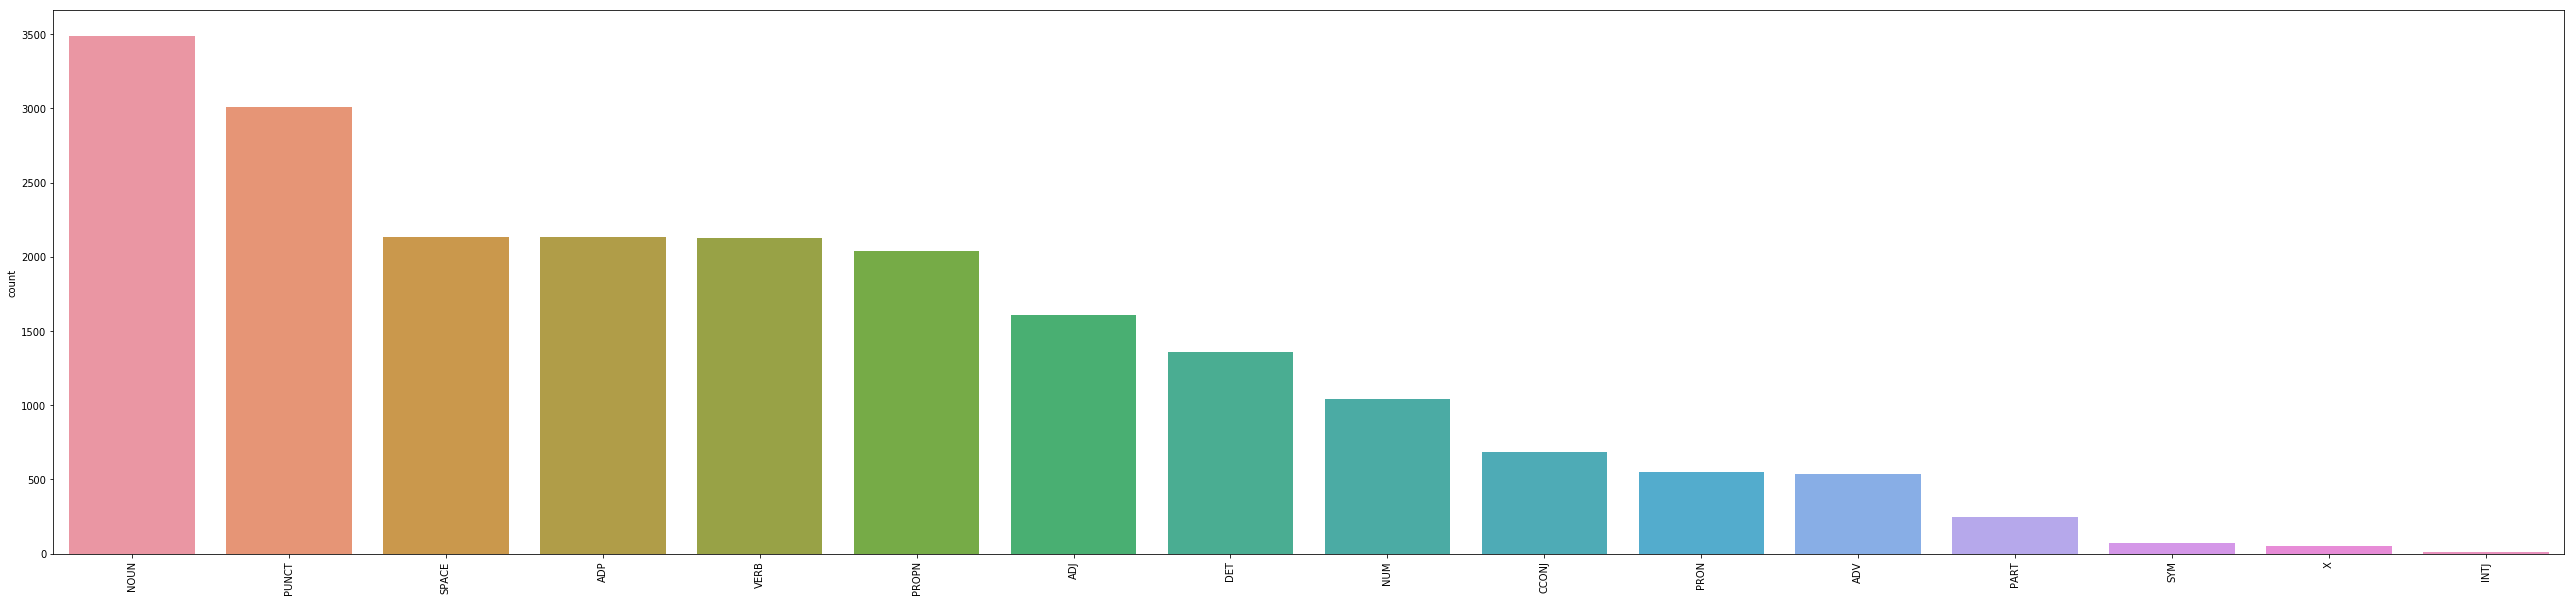

In [30]:
plt.figure(figsize=(45,10))
sns.countplot(tokens, order=pd.Series(tokens).value_counts().index)
# sns.countplot(words_nostop, order=[counted[0] for counted in Counter(words_nostop).most_common()])
plt.xticks(rotation=90)
plt.show()

***TODO: Insert explanation***

## Q3. (10 pts.) Make wordclouds for 5 books
- Use the [```word_cloud```](https://github.com/amueller/word_cloud) package.
- (8 pts.) Create a wordcloud for 5 books that you choose.
  - The author of each book should be different.
- (2pts.) Provide your interpretation.

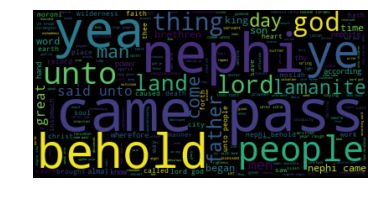

In [7]:
word_text = lower_nostop_alpha_data.copy()
word_text.content = word_text.content.str.replace('\n', '')

text = word_text.content[0]
wordcloud = WordCloud().generate(text)

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

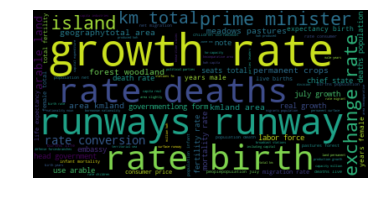

In [14]:
text = word_text.content[1]
wordcloud = WordCloud().generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

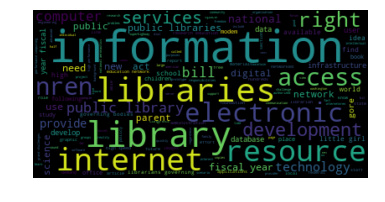

In [15]:
text = word_text.content[2]
wordcloud = WordCloud().generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

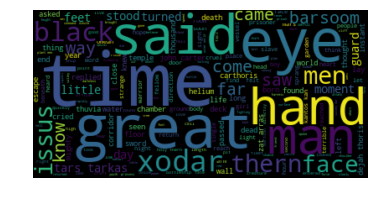

In [16]:
text = word_text.content[3]
wordcloud = WordCloud().generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

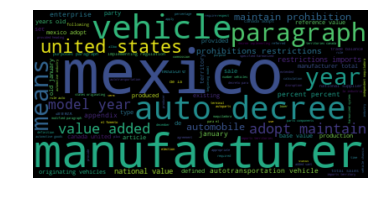

In [18]:
text = word_text.content[4]
wordcloud = WordCloud().generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

***TODO: Insert explanation***

## Q4. (bonus 5 pts.) Train your own word2vec vector.
- Use the ```gensim``` package
  - Your input will be the output from Q1 (cleaned data)
- Hint: You can look into this tutorial for training the new Word2Vec model: https://rare-technologies.com/word2vec-tutorial/
- Use default parameters when you train the Word2Vec model (e.g., ```min_count```, ```size```, etc.), except the number of workers (```workers=?```) parameter.
- Use this model for the later questions. 
  - **If you do not have your Word2Vec model, please use the pre-trained model that we used for the lab to answer the later questions**

In [15]:
class Sentences(object):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        
    def __iter__(self):
        sentences = list()
        for index, row in self.dataframe.iterrows():
            sentences = row.content.split('.')
            for sentence in sentences:
                yield [sentence]
                
sentences = Sentences(word_text)
model = Word2Vec(sentences)

RuntimeError: you must first build vocabulary before training the model

## Q5. (15 pts.) Similarity from Word2Vec 
- Choose 5 words
- (5pts.) What are the top-10 similar words of each?
- (5pts.) Do you find anything odd or interesting? Please explanation. 
  - (if you have your own word2vec model)How the results are different from the pre-trained model that we used in the lab?

## Q6. (20 pts.) Similarity between chapters 
- (5 pts.) Pick 5 chapters from the dataset and describe.
  - Each "chapter" consists of 10 consecutive paragraphs from a single book.
  - The author of each chapter should be different.
  - If necessary, explain how you defined "paragraph". 
- (5 pts.) Calculate the average of vectors for the words included in a chapter.  
  - In this way, you can have a vector that can roughly summarize the contents.    
  - The average vector should have the same dimensionality with word vectors 
    - e.g., if the word vector is a 100 dimension, the average vector for paragraph should be a 100 dimension as well
  - Words should come from the results of Q1 (cleaned out data) (i.e. should not contain stopwords or other special characters).
- (5 pts.) Calculate the similarity between chapters.  
  - Provide your interpretation. 
  - Why do you think some chapters are similar/dissimilar to others?

## Q7. (15 pts.) Word clustering
- Pick top-100 similar words with the word *information*.  
- Calculate cosine similarity scores between words
  - e.g., Create a 100x100 matrix that contains cosine similarity scores. Each row and columns should be words. 
- Use seaborn's [```.clustermap()```](https://seaborn.pydata.org/generated/seaborn.clustermap.html) function to draw a hierarchically-clustered heatmap
- Provide your interpretation